In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
from matplotlib.ticker import FuncFormatter, MultipleLocator
%matplotlib inline

In [2]:
import seaborn as sns
plt.rcParams['font.family'] = 'Helvetica'
sns.set(style='white',  font_scale=1.5)

In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [4]:
pna_a = pd.read_csv('./00_PNA/with_aca.csv', index_col=0)
gat_a = pd.read_csv('./01_GAT/with_aca.csv', index_col=0)
gcn_a = pd.read_csv('./02_GCN/with_aca.csv', index_col=0)
gin_a = pd.read_csv('./03_GIN/with_aca.csv', index_col=0)


pna = pd.read_csv('./00_PNA/without_aca.csv', index_col=0)
gat = pd.read_csv('./01_GAT/without_aca.csv', index_col=0)
gcn = pd.read_csv('./02_GCN/without_aca.csv', index_col=0)
gin = pd.read_csv('./03_GIN/without_aca.csv', index_col=0)


pna['seed'] = pna_a.seed
gat['seed'] = gat_a.seed
gcn['seed'] = gcn_a.seed
gin['seed'] = gin_a.seed

In [5]:
# y = 'n_pos_triplets'

# for df in [pna, gat, gcn, gin, pna_a, gat_a, gcn_a, gin_a]:
#     df[y] = np.log2(df[y])


# y = 'val_n_pos_triplets'
# for df in [pna, gat, gcn, gin, pna_a, gat_a, gcn_a, gin_a]:
#     df[y] = np.log2(df[y])

In [6]:
colors1 = sns.color_palette(palette = 'Set1', n_colors=4)
colors2 = sns.color_palette(palette = 'Blues_r', n_colors=4) #sns.dark_palette("#69d", n_colors=4) #
l2 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
l1 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'

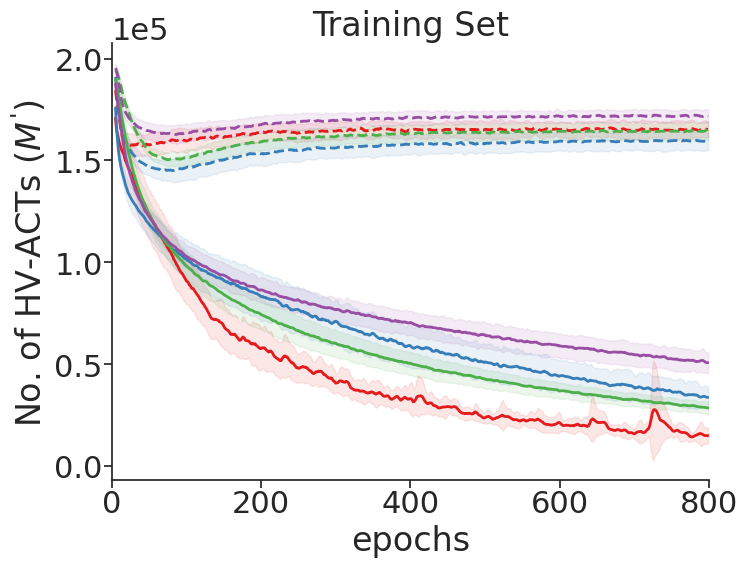

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 6.2), ncols = 1, sharey=False)


y = 'n_pos_triplets'

res = []
res1_std = []
for df, name in zip([pna, gat, gcn, gin], ['PNA($\mathcal{L}_{mae}$)', 'GAT($\mathcal{L}_{mae}$)', 'GCN($\mathcal{L}_{mae}$)', 'GIN($\mathcal{L}_{mae}$)']):
    dfp1 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp1_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    res1_std.append(dfp1_std)    
    res.append(dfp1)

dfp1 = pd.concat(res, axis=1)
dfp1_std = pd.concat(res1_std, axis=1)

dfp1.rolling(5).mean().plot(ax=ax1, lw = 2, ls = 'dashed', color = colors1)

ax1.set_ylabel("No. of HV-ACTs ($M^'$)")

min = dfp1 - dfp1_std
max = dfp1 + dfp1_std
for i,col in enumerate(dfp1.columns):
    ax1.fill_between(dfp1.index, min[col].rolling(5).mean(), max[col].rolling(5).mean(), alpha=0.1, color = colors1[i])
    
ax1.spines[['right', 'top']].set_visible(False)


res2 = []
res2_std = []
for df, name in zip([pna_a, gat_a, gcn_a, gin_a], ['PNA($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GAT($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GCN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GIN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)']):
    dfp2 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp2_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    
    res2.append(dfp2)
    res2_std.append(dfp2_std)
    
dfp2 = pd.concat(res2, axis=1)
dfp2_std = pd.concat(res2_std, axis=1)
dfp2.rolling(5).mean().plot(ax=ax1, lw = 2, ls = '-', color = colors1)

min = dfp2 - dfp2_std
max = dfp2 + dfp2_std
for i,col in enumerate(dfp2.columns):
    ax1.fill_between(dfp2.index, min[col].rolling(5).mean(), max[col].rolling(5).mean(), alpha=0.1, color = colors1[i])
    
ax1.spines[['right', 'top']].set_visible(False)

ax1.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

ax1.set_xlim(0,800)

ax1.set_xlabel('epochs')
ax1.get_legend().set_visible(False)


ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


ax1.set_title('Training Set')

fig.tight_layout(w_pad = 1)


fig.savefig('./gnn_HVACT_train.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./gnn_HVACT_train.pdf', bbox_inches='tight', dpi=400) 


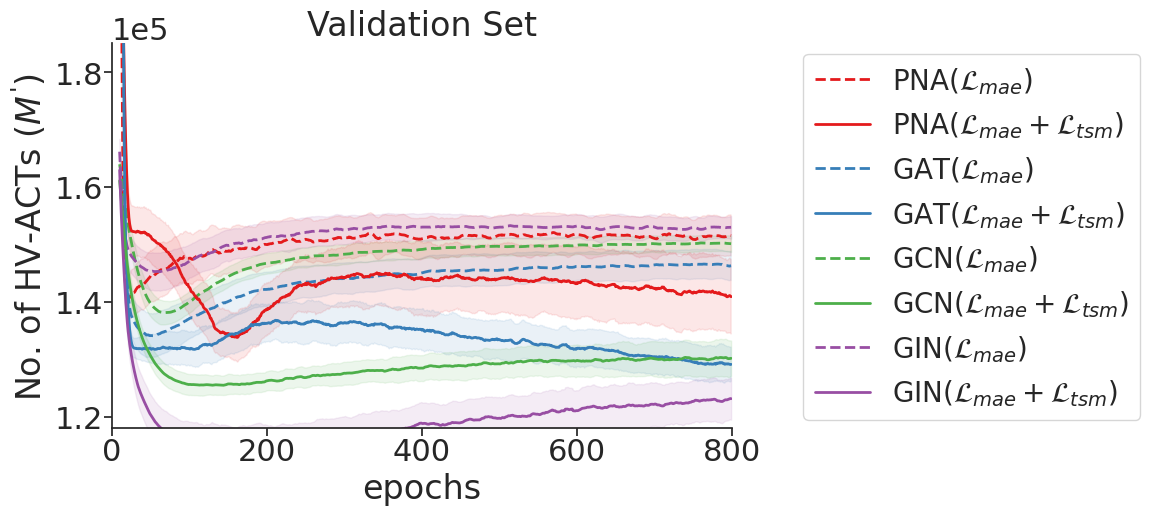

In [8]:
fig, ax2 = plt.subplots(figsize=(8, 5), ncols = 1, sharey=False)

###############################################################################################################
y = 'val_n_pos_triplets'

m = 10
res = []
res1_std = []
for df, name in zip([pna, gat, gcn, gin], ['PNA($\mathcal{L}_{mae}$)', 'GAT($\mathcal{L}_{mae}$)', 'GCN($\mathcal{L}_{mae}$)', 'GIN($\mathcal{L}_{mae}$)']):

    #df = df.groupby('Epoch').rolling(20).mean().reset_index()
    
    dfp1 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp1_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    res1_std.append(dfp1_std)    
    res.append(dfp1)

dfp1 = pd.concat(res, axis=1)
dfp1_std = pd.concat(res1_std, axis=1)*0.5

dfp1.rolling(m).mean().plot(ax=ax2, lw = 2, ls = '--', color = colors1)

#ax2.set_ylabel("No. of HV-ACTs ($M^'$)")

min = dfp1 - dfp1_std
max = dfp1 + dfp1_std
for i,col in enumerate(dfp1.columns):
    ax2.fill_between(dfp1.index, min[col].rolling(m).mean(), max[col].rolling(m).mean(), alpha=0.1, color = colors1[i])
    
ax2.spines[['right', 'top']].set_visible(False)


res2 = []
res2_std = []
for df, name in zip([pna_a, gat_a, gcn_a, gin_a], ['PNA($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GAT($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GCN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GIN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)']):
    #df = df.groupby('Epoch').rolling(20).mean().reset_index()
    
    dfp2 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp2_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    
    res2.append(dfp2)
    res2_std.append(dfp2_std)
    
dfp2 = pd.concat(res2, axis=1)
dfp2_std = pd.concat(res2_std, axis=1)*0.5
dfp2.rolling(m).mean().plot(ax=ax2, lw = 2, ls = '-', color = colors1)

min = dfp2 - dfp2_std
max = dfp2 + dfp2_std
for i,col in enumerate(dfp2.columns):
    ax2.fill_between(dfp2.index, min[col].rolling(m).mean(), max[col].rolling(m).mean(), alpha=0.1, color = colors1[i])
    
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

ax2.set_xlim(0,800)

ax2.set_xlabel('epochs')
ax2.get_legend().set_visible(False)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(1.18e5, 1.85e5)
ax2.yaxis.set_major_locator(MultipleLocator(0.2e5))

handles, labels = ax1.get_legend_handles_labels()

labels = [labels[0], labels[4], labels[1], labels[5],  labels[2], labels[6],  labels[3], labels[7] ]
handles = [handles[0], handles[4], handles[1], handles[5],  handles[2], handles[6],  handles[3], handles[7] ]

fig.legend(handles, labels,  loc='lower center', bbox_to_anchor=(1.2, 0.1), ncols = 1, fontsize=  20)

ax2.set_title('Validation Set')
ax2.set_ylabel("No. of HV-ACTs ($M^'$)")

# n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
# n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'

# ax1.set_title(n2, )
# ax2.set_title(n1, )

fig.savefig('./gnn_HVACT_validation.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./gnn_HVACT_validation.pdf', bbox_inches='tight', dpi=400) 


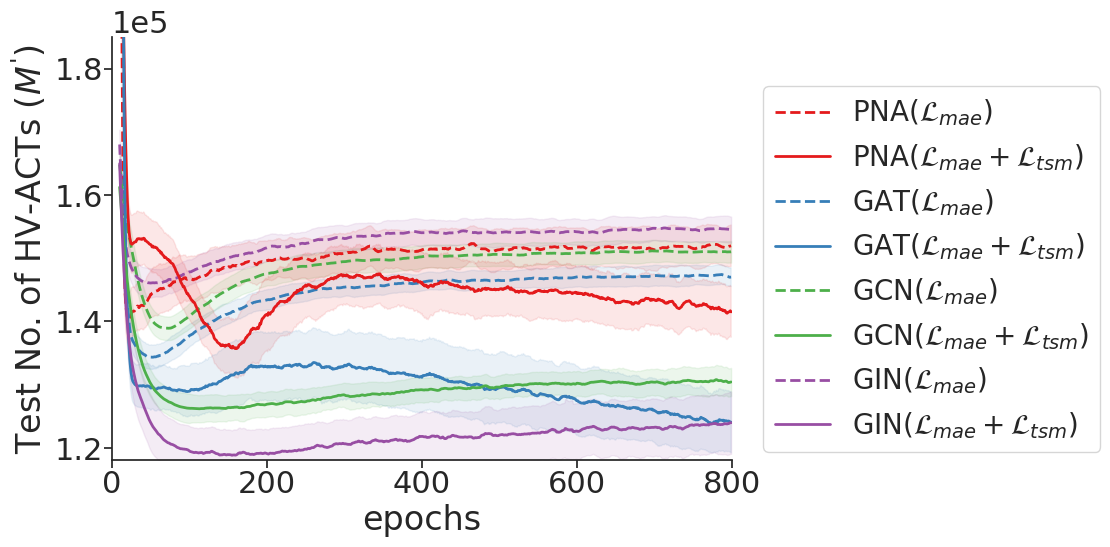

In [9]:
fig, ax2 = plt.subplots(figsize=(8, 5.5), ncols = 1, sharey=False)

###############################################################################################################
y = 'test_n_pos_triplets'

m = 10
res = []
res1_std = []
for df, name in zip([pna, gat, gcn, gin], ['PNA($\mathcal{L}_{mae}$)', 'GAT($\mathcal{L}_{mae}$)', 'GCN($\mathcal{L}_{mae}$)', 'GIN($\mathcal{L}_{mae}$)']):

    #df = df.groupby('Epoch').rolling(20).mean().reset_index()
    
    dfp1 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp1_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    res1_std.append(dfp1_std)    
    res.append(dfp1)

dfp1 = pd.concat(res, axis=1)
dfp1_std = pd.concat(res1_std, axis=1)*0.5

dfp1.rolling(m).mean().plot(ax=ax2, lw = 2, ls = '--', color = colors1)

#ax2.set_ylabel("No. of HV-ACTs ($M^'$)")

min = dfp1 - dfp1_std
max = dfp1 + dfp1_std
for i,col in enumerate(dfp1.columns):
    ax2.fill_between(dfp1.index, min[col].rolling(m).mean(), max[col].rolling(m).mean(), alpha=0.1, color = colors1[i])
    
ax2.spines[['right', 'top']].set_visible(False)


res2 = []
res2_std = []
for df, name in zip([pna_a, gat_a, gcn_a, gin_a], ['PNA($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GAT($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GCN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)', 
                                                   'GIN($\mathcal{L}_{mae}+\mathcal{L}_{tsm}$)']):
    #df = df.groupby('Epoch').rolling(20).mean().reset_index()
    
    dfp2 = df.groupby('Epoch').mean()[y].to_frame(name = name)
    dfp2_std = df.groupby('Epoch').std()[y].to_frame(name = name)
    
    res2.append(dfp2)
    res2_std.append(dfp2_std)
    
dfp2 = pd.concat(res2, axis=1)
dfp2_std = pd.concat(res2_std, axis=1)*0.5
dfp2.rolling(m).mean().plot(ax=ax2, lw = 2, ls = '-', color = colors1)

min = dfp2 - dfp2_std
max = dfp2 + dfp2_std
for i,col in enumerate(dfp2.columns):
    ax2.fill_between(dfp2.index, min[col].rolling(m).mean(), max[col].rolling(m).mean(), alpha=0.1, color = colors1[i])
    
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

ax2.set_xlim(0,800)

ax2.set_xlabel('epochs')
ax2.get_legend().set_visible(False)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(1.18e5, 1.85e5)
ax2.yaxis.set_major_locator(MultipleLocator(0.2e5))

handles, labels = ax1.get_legend_handles_labels()

labels = [labels[0], labels[4], labels[1], labels[5],  labels[2], labels[6],  labels[3], labels[7] ]
handles = [handles[0], handles[4], handles[1], handles[5],  handles[2], handles[6],  handles[3], handles[7] ]

fig.legend(handles, labels,  loc='lower center', bbox_to_anchor=(1.15, 0.1), ncols = 1, fontsize=  20)

#ax2.set_title('Test Set')
ax2.set_ylabel("Test No. of HV-ACTs ($M^'$)")

# n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
# n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'

# ax1.set_title(n2, )
# ax2.set_title(n1, )

fig.savefig('./gnn_HVACT_test.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./gnn_HVACT_test.pdf', bbox_inches='tight', dpi=400) 


In [10]:
l2 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
l1 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'

best_res = []
for df, name, loss in zip([pna, gat, gcn, gin,          pna_a, gat_a, gcn_a, gin_a], 
                          ['PNA', 'GAT', 'GCN', 'GIN',  'PNA', 'GAT', 'GCN', 'GIN'], 
                          [l1,l1,l1,l1,                   l2,l2,l2,l2]):

    best = df.iloc[df.reset_index().groupby('seed').apply(lambda x:x.rolling(2).mean().val_rmse.idxmin())]
    best.loc[:,'backbone'] = name
    best.loc[:,'loss'] = loss
    best_res.append(best)

best = pd.concat(best_res,axis=0).reset_index(drop=True)
best

/tmp/ipykernel_39541/1800940021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best.loc[:,'backbone'] = name
/tmp/ipykernel_39541/1800940021.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best.loc[:,'loss'] = loss
/tmp/ipykernel_39541/1800940021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Epoch,train_loss,train_triplet_loss,train_mae_loss,val_rmse,test_rmse,train_rmse,n_triplets,n_pos_triplets,train_n_pos_triplets,val_n_pos_triplets,test_n_pos_triplets,seed,backbone,loss
0,732,0.017884,482.122525,0.017884,0.709920,0.637567,0.134312,406026,158248,155548,141062,137396,8,PNA,Without AC-awareness ($\mathcal{L}_{mae}$)
1,765,0.012785,496.955760,0.012785,0.786376,0.679605,0.096819,409764,167019,163926,156362,147305,16,PNA,Without AC-awareness ($\mathcal{L}_{mae}$)
2,788,0.008890,547.609483,0.008890,0.733290,0.787259,0.078670,408255,163165,161986,150538,155432,24,PNA,Without AC-awareness ($\mathcal{L}_{mae}$)
3,624,0.020836,834.178170,0.020836,0.729586,0.688435,0.129169,404787,172361,172266,166146,160482,42,PNA,Without AC-awareness ($\mathcal{L}_{mae}$)
4,734,0.013527,500.489154,0.013527,0.661156,0.714392,0.112221,403740,163394,162643,144932,150780,64,PNA,Without AC-awareness ($\mathcal{L}_{mae}$)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,260,5.125065,4.895221,0.229844,0.684633,0.711213,0.432050,404744,79468,74817,110498,123740,128,GIN,With AC-awareness ($\mathcal{L}_{mae} + \mathc...
76,252,5.572319,5.343730,0.228589,0.605597,0.758742,0.440166,407901,81108,74327,105241,132457,256,GIN,With AC-awareness ($\mathcal{L}_{mae} + \mathc...
77,603,1.867476,1.727914,0.139562,0.633202,0.646916,0.347228,407846,70235,63106,121394,130114,512,GIN,With AC-awareness ($\mathcal{L}_{mae} + \mathc...
78,782,0.983792,0.874217,0.109575,0.583832,0.711142,0.290697,406218,52735,49337,119451,133619,1024,GIN,With AC-awareness ($\mathcal{L}_{mae} + \mathc...


In [11]:
best.to_csv('barplot_raw.csv')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GAT_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GAT_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=2.264e-02 stat=2.745e+00
PNA_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. PNA_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=6.001e-04 stat=5.154e+00
GCN_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GCN_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=1.403e-02 stat=3.040e+00
GIN_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GIN_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=2.581e-02 stat=2.666e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <

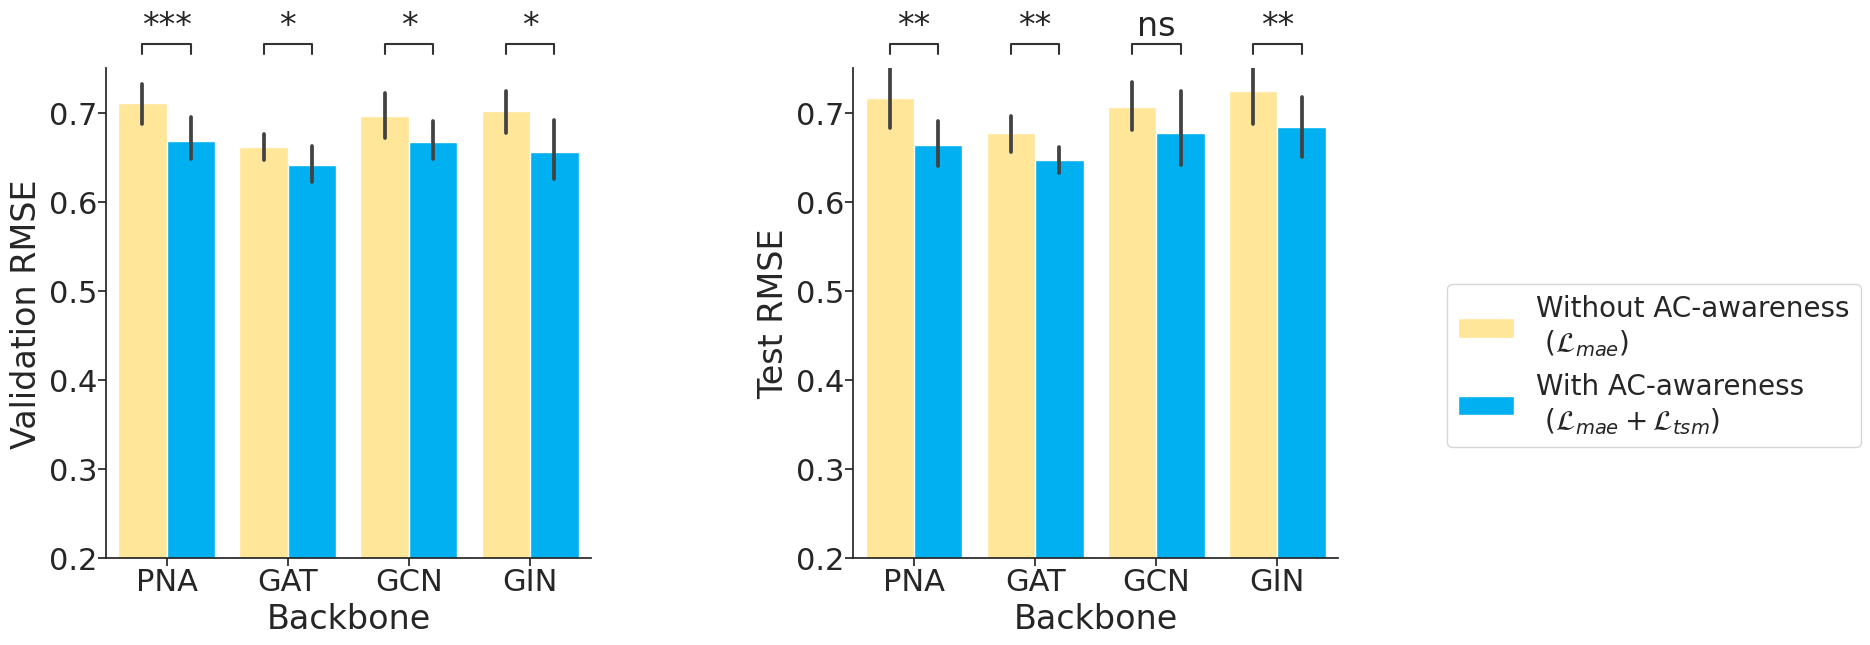

In [12]:
ys = ['val_rmse', 'test_rmse']
ns = ['Validation RMSE', 'Test RMSE']
colors = ['#FFE699','#00B0F0']
#colors = [colors1[2], colors2[1]]

fig, axes = plt.subplots(figsize=(7*2, 7), ncols=2 )


for ax, y, yl in zip(axes, ys, ns):
    
    #sns.swarmplot(data = best, x = 'backbone', y = 'val_rmse', hue = 'loss',ax=ax, palette=colors, dodge=True, legend = None, zorder=2)
    sns.barplot(data = best, x = 'backbone', y = y, hue = 'loss', ax=ax, palette=colors, saturation=1)
    
    ax.get_legend().set_visible(False)
    ax.set_ylim(0.2, 0.75)
    ax.set_ylabel(yl)
    ax.set_xlabel(None)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
    
    from statannot import add_stat_annotation
    
    box_pairs = [(('PNA', l1), ('PNA', l2)), (('GAT', l1), ('GAT', l2)), (('GCN', l1), ('GCN', l2)), (('GIN', l1), ('GIN', l2))]
    
    add_stat_annotation(ax, data = best, 
                        x = 'backbone', y = y, 
                        hue = 'loss', #plot='barplot',
                        box_pairs=box_pairs,
                        test='t-test_paired', 
                        comparisons_correction = None,
                        text_format='star', 
                        loc='outside', verbose=2)
    # fig.savefig('./gnn_val_rmse.svg', bbox_inches='tight', dpi=400) 
    # fig.savefig('./gnn_val_rmse.pdf', bbox_inches='tight', dpi=400) 
    ax.set_xlabel('Backbone')


fig.tight_layout(w_pad = 5)

handles, labels = ax.get_legend_handles_labels()
labels = [i.replace('AC-awareness', 'AC-awareness\n') for i in  labels]
fig.legend(handles, labels,  loc='lower center', bbox_to_anchor=(1.2, 0.3), ncols = 1, fontsize=  20)


fig.savefig('./gnn_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./gnn_RMSE.pdf', bbox_inches='tight', dpi=400) 

In [13]:
order = [ 'GCN', 'GIN', 'GAT', 'PNA']


In [14]:
y = 'val_rmse'
mean = best.groupby(['backbone', 'loss'])[y].mean().unstack().round(3).astype(str)
std = best.groupby(['backbone', 'loss'])[y].std().unstack().round(3).astype(str)
res = mean + '±' + std
res.loc[order][[l1,l2]]

loss,Without AC-awareness ($\mathcal{L}_{mae}$),With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)
backbone,,
GCN,0.696±0.044,0.667±0.036
GIN,0.702±0.04,0.656±0.057
GAT,0.662±0.025,0.642±0.033
PNA,0.711±0.039,0.669±0.039


In [15]:
mean = best.groupby(['backbone', 'loss'])[y].mean().unstack()[[l1,l2]]
boost = (mean[l1] - mean[l2]) / mean[l1] * 100
mean['improvement'] = '↓ ' + boost.apply(lambda x: '%.2f' % x) + '%'
mean.loc[order]

loss,Without AC-awareness ($\mathcal{L}_{mae}$),With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$),improvement
backbone,,,
GCN,0.696458,0.667206,↓ 4.20%
GIN,0.701883,0.656121,↓ 6.52%
GAT,0.662062,0.642038,↓ 3.02%
PNA,0.710881,0.668959,↓ 5.90%


In [16]:
boost.mean()

4.910413921789759

In [17]:
mean[[l1,l2]].mean().round(3), mean[[l1,l2]].std().round(3)

(loss
 Without AC-awareness ($\mathcal{L}_{mae}$)                     0.693
 With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)    0.659
 dtype: float64,
 loss
 Without AC-awareness ($\mathcal{L}_{mae}$)                     0.021
 With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)    0.012
 dtype: float64)

In [18]:
y = 'test_rmse'
mean = best.groupby(['backbone', 'loss'])[y].mean().unstack().round(3).astype(str)
std = best.groupby(['backbone', 'loss'])[y].std().unstack().round(3).astype(str)
res = mean + '±' + std
res.loc[order][[l1,l2]]

loss,Without AC-awareness ($\mathcal{L}_{mae}$),With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)
backbone,,
GCN,0.707±0.045,0.678±0.074
GIN,0.725±0.063,0.685±0.06
GAT,0.678±0.036,0.647±0.024
PNA,0.716±0.06,0.664±0.045


In [19]:
order = [ 'GCN', 'GIN', 'GAT', 'PNA']

mean = best.groupby(['backbone', 'loss'])[y].mean().unstack()[[l1,l2]]
boost = (mean[l1] - mean[l2]) / mean[l1] * 100
mean['improvement'] = '↓ ' + boost.apply(lambda x: '%.2f' % x) + '%'
mean.loc[order]

loss,Without AC-awareness ($\mathcal{L}_{mae}$),With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$),improvement
backbone,,,
GCN,0.707007,0.677663,↓ 4.15%
GIN,0.724852,0.684712,↓ 5.54%
GAT,0.677677,0.647035,↓ 4.52%
PNA,0.716307,0.664440,↓ 7.24%


In [20]:
boost.mean()

5.362694183976541

In [21]:
mean[[l1,l2]].mean().round(3), mean[[l1,l2]].std().round(3)

(loss
 Without AC-awareness ($\mathcal{L}_{mae}$)                     0.706
 With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)    0.668
 dtype: float64,
 loss
 Without AC-awareness ($\mathcal{L}_{mae}$)                     0.021
 With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)    0.017
 dtype: float64)

In [22]:
y = 'train_rmse'
mean = best.groupby(['backbone', 'loss'])[y].mean().unstack().round(3).astype(str)
std = best.groupby(['backbone', 'loss'])[y].std().unstack().round(3).astype(str)
mean + '±' + std

loss,With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$),Without AC-awareness ($\mathcal{L}_{mae}$)
backbone,,
GAT,0.313±0.093,0.211±0.153
GCN,0.245±0.04,0.198±0.131
GIN,0.355±0.089,0.217±0.146
PNA,0.22±0.09,0.142±0.128


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GAT_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GAT_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=2.998e-03 stat=4.024e+00
PNA_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. PNA_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=2.959e-03 stat=4.033e+00
GCN_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GCN_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=1.553e-01 stat=1.551e+00
GIN_Without AC-awareness ($\mathcal{L}_{mae}$) v.s. GIN_With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$): t-test paired samples, P_val=6.648e-03 stat=3.507e+00


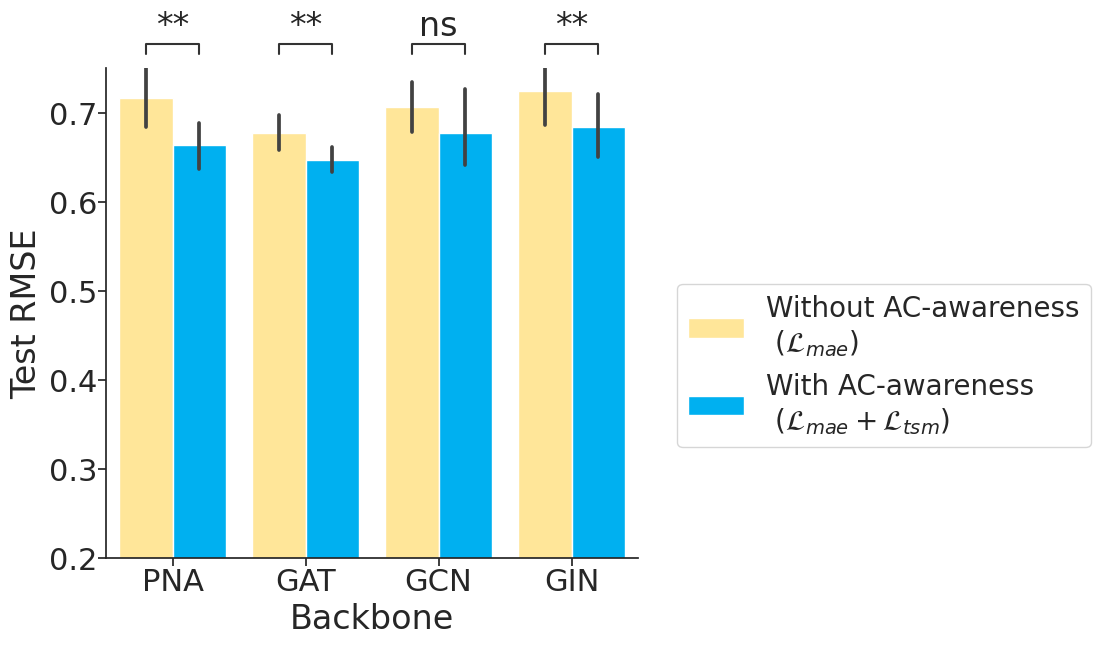

In [23]:
ys = ['val_rmse', 'test_rmse']
ns = ['Validation RMSE', 'Test RMSE']
colors = ['#FFE699','#00B0F0']
#colors = [colors1[2], colors2[1]]

fig, ax = plt.subplots(figsize=(7, 7), ncols=1 )


y = ys[1]
y1 = ns[1]
 
#sns.swarmplot(data = best, x = 'backbone', y = 'val_rmse', hue = 'loss',ax=ax, palette=colors, dodge=True, legend = None, zorder=2)
sns.barplot(data = best, x = 'backbone', y = y, hue = 'loss', ax=ax, palette=colors, saturation=1)

ax.get_legend().set_visible(False)
ax.set_ylim(0.2, 0.75)
ax.set_ylabel(yl)
ax.set_xlabel(None)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

from statannot import add_stat_annotation

box_pairs = [(('PNA', l1), ('PNA', l2)), (('GAT', l1), ('GAT', l2)), (('GCN', l1), ('GCN', l2)), (('GIN', l1), ('GIN', l2))]

add_stat_annotation(ax, data = best, 
                    x = 'backbone', y = y, 
                    hue = 'loss', #plot='barplot',
                    box_pairs=box_pairs,
                    test='t-test_paired', 
                    comparisons_correction = None,
                    text_format='star', 
                    loc='outside', verbose=2)
# fig.savefig('./gnn_val_rmse.svg', bbox_inches='tight', dpi=400) 
# fig.savefig('./gnn_val_rmse.pdf', bbox_inches='tight', dpi=400) 
ax.set_xlabel('Backbone')


fig.tight_layout(w_pad = 5)

handles, labels = ax.get_legend_handles_labels()
labels = [i.replace('AC-awareness', 'AC-awareness\n') for i in  labels]
fig.legend(handles, labels,  loc='lower center', bbox_to_anchor=(1.3, 0.3), ncols = 1, fontsize=  20)


fig.savefig('./gnn_RMSE_test.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./gnn_RMSE_test.pdf', bbox_inches='tight', dpi=400) 